In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 1000,
    'patience'      : 4,
    'dropout'       : 0.75,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_1000_075_1024_512_256_128_0001_MSE_4_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_b25_t1_mask_t1t2_normalized_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 920)
(734160, 1)
validation
(101248, 920)
(101248, 1)
test
(100432, 920)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 920)]             0         


 dense (Dense)               (None, 1024)              943104    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1632257 (6.23 MB)


Trainable params: 1632257 (6.23 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/735 [..............................] - ETA: 12:26 - loss: 0.1018 - STD: 1.4145e-04 - MAE: 0.3059

 16/735 [..............................] - ETA: 2s - loss: 0.0268 - STD: 1.1343e-04 - MAE: 0.1289   

 32/735 [>.............................] - ETA: 2s - loss: 0.0188 - STD: 9.7846e-05 - MAE: 0.1063

 48/735 [>.............................] - ETA: 2s - loss: 0.0158 - STD: 9.0826e-05 - MAE: 0.0963

 63/735 [=>............................] - ETA: 2s - loss: 0.0143 - STD: 9.7101e-05 - MAE: 0.0913

 79/735 [==>...........................] - ETA: 2s - loss: 0.0133 - STD: 1.1373e-04 - MAE: 0.0883

 95/735 [==>...........................] - ETA: 2s - loss: 0.0126 - STD: 1.4080e-04 - MAE: 0.0860

112/735 [===>..........................] - ETA: 2s - loss: 0.0121 - STD: 1.8657e-04 - MAE: 0.0845

127/735 [====>.........................] - ETA: 2s - loss: 0.0118 - STD: 2.5372e-04 - MAE: 0.0835

142/735 [====>.........................] - ETA: 1s - loss: 0.0115 - STD: 3.6828e-04 - MAE: 0.0826

158/735 [=====>........................] - ETA: 1s - loss: 0.0113 - STD: 6.0329e-04 - MAE: 0.0819

173/735 [======>.......................] - ETA: 1s - loss: 0.0110 - STD: 0.0010 - MAE: 0.0811    

188/735 [======>.......................] - ETA: 1s - loss: 0.0108 - STD: 0.0020 - MAE: 0.0803

203/735 [=======>......................] - ETA: 1s - loss: 0.0106 - STD: 0.0038 - MAE: 0.0794

218/735 [=======>......................] - ETA: 1s - loss: 0.0103 - STD: 0.0062 - MAE: 0.0785

233/735 [========>.....................] - ETA: 1s - loss: 0.0101 - STD: 0.0087 - MAE: 0.0775

248/735 [=========>....................] - ETA: 1s - loss: 0.0099 - STD: 0.0112 - MAE: 0.0766

263/735 [=========>....................] - ETA: 1s - loss: 0.0096 - STD: 0.0135 - MAE: 0.0756

279/735 [==========>...................] - ETA: 1s - loss: 0.0094 - STD: 0.0159 - MAE: 0.0746

295/735 [===========>..................] - ETA: 1s - loss: 0.0092 - STD: 0.0181 - MAE: 0.0737

311/735 [===========>..................] - ETA: 1s - loss: 0.0090 - STD: 0.0203 - MAE: 0.0727

320/735 [============>.................] - ETA: 1s - loss: 0.0089 - STD: 0.0214 - MAE: 0.0722

332/735 [============>.................] - ETA: 1s - loss: 0.0088 - STD: 0.0228 - MAE: 0.0716

346/735 [=============>................] - ETA: 1s - loss: 0.0086 - STD: 0.0243 - MAE: 0.0709

361/735 [=============>................] - ETA: 1s - loss: 0.0085 - STD: 0.0259 - MAE: 0.0702

377/735 [==============>...............] - ETA: 1s - loss: 0.0083 - STD: 0.0274 - MAE: 0.0695

393/735 [===============>..............] - ETA: 1s - loss: 0.0082 - STD: 0.0289 - MAE: 0.0688

409/735 [===============>..............] - ETA: 1s - loss: 0.0080 - STD: 0.0302 - MAE: 0.0683

424/735 [================>.............] - ETA: 1s - loss: 0.0079 - STD: 0.0314 - MAE: 0.0678

441/735 [=================>............] - ETA: 1s - loss: 0.0078 - STD: 0.0327 - MAE: 0.0672

455/735 [=================>............] - ETA: 1s - loss: 0.0077 - STD: 0.0337 - MAE: 0.0667

471/735 [==================>...........] - ETA: 1s - loss: 0.0076 - STD: 0.0348 - MAE: 0.0663

488/735 [==================>...........] - ETA: 1s - loss: 0.0075 - STD: 0.0358 - MAE: 0.0658

505/735 [===================>..........] - ETA: 0s - loss: 0.0074 - STD: 0.0369 - MAE: 0.0653

521/735 [====================>.........] - ETA: 0s - loss: 0.0073 - STD: 0.0378 - MAE: 0.0649

537/735 [====================>.........] - ETA: 0s - loss: 0.0072 - STD: 0.0386 - MAE: 0.0645

552/735 [=====================>........] - ETA: 0s - loss: 0.0072 - STD: 0.0393 - MAE: 0.0641

568/735 [======================>.......] - ETA: 0s - loss: 0.0071 - STD: 0.0400 - MAE: 0.0638

583/735 [======================>.......] - ETA: 0s - loss: 0.0071 - STD: 0.0406 - MAE: 0.0636

597/735 [=======================>......] - ETA: 0s - loss: 0.0070 - STD: 0.0412 - MAE: 0.0633

612/735 [=======================>......] - ETA: 0s - loss: 0.0069 - STD: 0.0418 - MAE: 0.0630

627/735 [========================>.....] - ETA: 0s - loss: 0.0069 - STD: 0.0424 - MAE: 0.0628

642/735 [=========================>....] - ETA: 0s - loss: 0.0068 - STD: 0.0430 - MAE: 0.0625

658/735 [=========================>....] - ETA: 0s - loss: 0.0068 - STD: 0.0436 - MAE: 0.0622

674/735 [==========================>...] - ETA: 0s - loss: 0.0067 - STD: 0.0441 - MAE: 0.0620

690/735 [===========================>..] - ETA: 0s - loss: 0.0067 - STD: 0.0447 - MAE: 0.0617

706/735 [===========================>..] - ETA: 0s - loss: 0.0066 - STD: 0.0452 - MAE: 0.0615

721/735 [============================>.] - ETA: 0s - loss: 0.0066 - STD: 0.0456 - MAE: 0.0613

735/735 [==============================] - 5s 5ms/step - loss: 0.0065 - STD: 0.0460 - MAE: 0.0611 - val_loss: 0.0038 - val_STD: 0.0449 - val_MAE: 0.0458


Epoch 2/10000


  1/735 [..............................] - ETA: 12s - loss: 0.0036 - STD: 0.0657 - MAE: 0.0453

 16/735 [..............................] - ETA: 2s - loss: 0.0044 - STD: 0.0678 - MAE: 0.0504 

 32/735 [>.............................] - ETA: 2s - loss: 0.0045 - STD: 0.0678 - MAE: 0.0508

 46/735 [>.............................] - ETA: 2s - loss: 0.0045 - STD: 0.0688 - MAE: 0.0508

 62/735 [=>............................] - ETA: 2s - loss: 0.0045 - STD: 0.0687 - MAE: 0.0506

 78/735 [==>...........................] - ETA: 2s - loss: 0.0044 - STD: 0.0688 - MAE: 0.0504

 91/735 [==>...........................] - ETA: 2s - loss: 0.0044 - STD: 0.0689 - MAE: 0.0504

106/735 [===>..........................] - ETA: 2s - loss: 0.0045 - STD: 0.0687 - MAE: 0.0505

121/735 [===>..........................] - ETA: 2s - loss: 0.0045 - STD: 0.0685 - MAE: 0.0505

133/735 [====>.........................] - ETA: 2s - loss: 0.0044 - STD: 0.0687 - MAE: 0.0505

146/735 [====>.........................] - ETA: 2s - loss: 0.0044 - STD: 0.0687 - MAE: 0.0505

159/735 [=====>........................] - ETA: 2s - loss: 0.0044 - STD: 0.0686 - MAE: 0.0505

172/735 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0505

186/735 [======>.......................] - ETA: 1s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0504

198/735 [=======>......................] - ETA: 1s - loss: 0.0044 - STD: 0.0686 - MAE: 0.0504

211/735 [=======>......................] - ETA: 1s - loss: 0.0044 - STD: 0.0687 - MAE: 0.0504

224/735 [========>.....................] - ETA: 1s - loss: 0.0044 - STD: 0.0687 - MAE: 0.0504

236/735 [========>.....................] - ETA: 1s - loss: 0.0044 - STD: 0.0686 - MAE: 0.0504

248/735 [=========>....................] - ETA: 1s - loss: 0.0044 - STD: 0.0686 - MAE: 0.0504

260/735 [=========>....................] - ETA: 1s - loss: 0.0044 - STD: 0.0686 - MAE: 0.0504

272/735 [==========>...................] - ETA: 1s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0503

284/735 [==========>...................] - ETA: 1s - loss: 0.0044 - STD: 0.0686 - MAE: 0.0503

296/735 [===========>..................] - ETA: 1s - loss: 0.0044 - STD: 0.0687 - MAE: 0.0502

309/735 [===========>..................] - ETA: 1s - loss: 0.0044 - STD: 0.0686 - MAE: 0.0502

323/735 [============>.................] - ETA: 1s - loss: 0.0044 - STD: 0.0686 - MAE: 0.0502

339/735 [============>.................] - ETA: 1s - loss: 0.0044 - STD: 0.0686 - MAE: 0.0502

351/735 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0687 - MAE: 0.0501

365/735 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0687 - MAE: 0.0501

380/735 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0688 - MAE: 0.0501

395/735 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0688 - MAE: 0.0501

410/735 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0688 - MAE: 0.0500

424/735 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0687 - MAE: 0.0501

437/735 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0688 - MAE: 0.0500

452/735 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0688 - MAE: 0.0500

467/735 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0688 - MAE: 0.0500

482/735 [==================>...........] - ETA: 0s - loss: 0.0044 - STD: 0.0689 - MAE: 0.0499

497/735 [===================>..........] - ETA: 0s - loss: 0.0044 - STD: 0.0689 - MAE: 0.0499

512/735 [===================>..........] - ETA: 0s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0498

527/735 [====================>.........] - ETA: 0s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0498

542/735 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0497

557/735 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0497

572/735 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0497

587/735 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0496

602/735 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0496

617/735 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0496

633/735 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0495

649/735 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0495

665/735 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0494

681/735 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0494

697/735 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0494

713/735 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0493

730/735 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0494

735/735 [==============================] - 3s 4ms/step - loss: 0.0043 - STD: 0.0694 - MAE: 0.0494 - val_loss: 0.0042 - val_STD: 0.0445 - val_MAE: 0.0464


Epoch 3/10000


  1/735 [..............................] - ETA: 15s - loss: 0.0048 - STD: 0.0585 - MAE: 0.0517

 14/735 [..............................] - ETA: 2s - loss: 0.0045 - STD: 0.0670 - MAE: 0.0506 

 29/735 [>.............................] - ETA: 2s - loss: 0.0043 - STD: 0.0681 - MAE: 0.0493

 44/735 [>.............................] - ETA: 2s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0490

 60/735 [=>............................] - ETA: 2s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0486

 76/735 [==>...........................] - ETA: 2s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0484

 92/735 [==>...........................] - ETA: 2s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0484

108/735 [===>..........................] - ETA: 2s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0481

123/735 [====>.........................] - ETA: 2s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0481

138/735 [====>.........................] - ETA: 2s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0480

154/735 [=====>........................] - ETA: 1s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0479

169/735 [=====>........................] - ETA: 1s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0479

184/735 [======>.......................] - ETA: 1s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0479

200/735 [=======>......................] - ETA: 1s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0478

216/735 [=======>......................] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0477

231/735 [========>.....................] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0477

247/735 [=========>....................] - ETA: 1s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0477

263/735 [=========>....................] - ETA: 1s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0477

279/735 [==========>...................] - ETA: 1s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0476

295/735 [===========>..................] - ETA: 1s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0475

310/735 [===========>..................] - ETA: 1s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0475

326/735 [============>.................] - ETA: 1s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0475

341/735 [============>.................] - ETA: 1s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0474

357/735 [=============>................] - ETA: 1s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0474

373/735 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0474

389/735 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0473

406/735 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0473

423/735 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0473

440/735 [================>.............] - ETA: 0s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0472

457/735 [=================>............] - ETA: 0s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0472

473/735 [==================>...........] - ETA: 0s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0472

488/735 [==================>...........] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0471

504/735 [===================>..........] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0470

519/735 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0470

534/735 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0470

550/735 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0469

566/735 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0469

581/735 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0468

597/735 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0468

613/735 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0468

629/735 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0467

645/735 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0467

661/735 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0467

674/735 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0466

687/735 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0466

701/735 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0466

715/735 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0466

730/735 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0465

735/735 [==============================] - 3s 4ms/step - loss: 0.0038 - STD: 0.0726 - MAE: 0.0465 - val_loss: 0.0031 - val_STD: 0.0577 - val_MAE: 0.0420


Epoch 4/10000


  1/735 [..............................] - ETA: 14s - loss: 0.0037 - STD: 0.0721 - MAE: 0.0468

 12/735 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0449 

 24/735 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0729 - MAE: 0.0450

 36/735 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0454

 51/735 [=>............................] - ETA: 2s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0455

 64/735 [=>............................] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0456

 79/735 [==>...........................] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0454

 93/735 [==>...........................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0452

107/735 [===>..........................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0453

122/735 [===>..........................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

137/735 [====>.........................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0453

149/735 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0452

162/735 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0451

178/735 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0451

192/735 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0450

204/735 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0451

216/735 [=======>......................] - ETA: 1s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0451

228/735 [========>.....................] - ETA: 1s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0451

241/735 [========>.....................] - ETA: 1s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0450

254/735 [=========>....................] - ETA: 1s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0450

267/735 [=========>....................] - ETA: 1s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0450

279/735 [==========>...................] - ETA: 1s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0450

293/735 [==========>...................] - ETA: 1s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0450

307/735 [===========>..................] - ETA: 1s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0450

322/735 [============>.................] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0450

336/735 [============>.................] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0450

349/735 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0450

365/735 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0450

381/735 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0450

398/735 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0450

413/735 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0450

428/735 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0450

443/735 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0449

456/735 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0449

470/735 [==================>...........] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0449

486/735 [==================>...........] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

500/735 [===================>..........] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

515/735 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0448

530/735 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0448

545/735 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0448

560/735 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

575/735 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0447

590/735 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0447

605/735 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0447

618/735 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0446

630/735 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0446

644/735 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0446

657/735 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0446

671/735 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0446

685/735 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0446

699/735 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

711/735 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0445

723/735 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0445

735/735 [==============================] - 3s 4ms/step - loss: 0.0035 - STD: 0.0747 - MAE: 0.0445 - val_loss: 0.0030 - val_STD: 0.0603 - val_MAE: 0.0405


Epoch 5/10000


  1/735 [..............................] - ETA: 15s - loss: 0.0030 - STD: 0.0739 - MAE: 0.0422

 16/735 [..............................] - ETA: 2s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0435 

 32/735 [>.............................] - ETA: 2s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0438

 48/735 [>.............................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0443

 63/735 [=>............................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

 77/735 [==>...........................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

 93/735 [==>...........................] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0440

109/735 [===>..........................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0441

123/735 [====>.........................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

135/735 [====>.........................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

148/735 [=====>........................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

163/735 [=====>........................] - ETA: 2s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0438

178/735 [======>.......................] - ETA: 1s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0438

194/735 [======>.......................] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

207/735 [=======>......................] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

221/735 [========>.....................] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

235/735 [========>.....................] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0439

251/735 [=========>....................] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

267/735 [=========>....................] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0437

284/735 [==========>...................] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0436

301/735 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0437

317/735 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0436

333/735 [============>.................] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0436

344/735 [=============>................] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0436

355/735 [=============>................] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

368/735 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

385/735 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0435

401/735 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

417/735 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

433/735 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

447/735 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

460/735 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

475/735 [==================>...........] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

491/735 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

507/735 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

523/735 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

538/735 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0433

552/735 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0433

565/735 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0433

581/735 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

596/735 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

611/735 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

623/735 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

637/735 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

653/735 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

669/735 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

686/735 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

701/735 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

716/735 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

729/735 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0431

735/735 [==============================] - 3s 4ms/step - loss: 0.0033 - STD: 0.0759 - MAE: 0.0431 - val_loss: 0.0029 - val_STD: 0.0647 - val_MAE: 0.0401


Epoch 6/10000


  1/735 [..............................] - ETA: 13s - loss: 0.0031 - STD: 0.0797 - MAE: 0.0421

 15/735 [..............................] - ETA: 2s - loss: 0.0032 - STD: 0.0758 - MAE: 0.0419 

 30/735 [>.............................] - ETA: 2s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0420

 46/735 [>.............................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

 61/735 [=>............................] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

 76/735 [==>...........................] - ETA: 2s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

 92/735 [==>...........................] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

107/735 [===>..........................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

122/735 [===>..........................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

138/735 [====>.........................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

153/735 [=====>........................] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

167/735 [=====>........................] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

182/735 [======>.......................] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

197/735 [=======>......................] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

212/735 [=======>......................] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

228/735 [========>.....................] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

245/735 [=========>....................] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

261/735 [=========>....................] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422

277/735 [==========>...................] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

292/735 [==========>...................] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

304/735 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

317/735 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

333/735 [============>.................] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

349/735 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

366/735 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

382/735 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

397/735 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

412/735 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

427/735 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

443/735 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

457/735 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

471/735 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

485/735 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

498/735 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

513/735 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

529/735 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

545/735 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

561/735 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

576/735 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

592/735 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

609/735 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

626/735 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

642/735 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

657/735 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

673/735 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

689/735 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

706/735 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

722/735 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

735/735 [==============================] - 3s 4ms/step - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417 - val_loss: 0.0032 - val_STD: 0.0684 - val_MAE: 0.0430


Epoch 7/10000


  1/735 [..............................] - ETA: 12s - loss: 0.0038 - STD: 0.0818 - MAE: 0.0453

 17/735 [..............................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0423 

 33/735 [>.............................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

 49/735 [=>............................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

 65/735 [=>............................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

 81/735 [==>...........................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

 97/735 [==>...........................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0410

113/735 [===>..........................] - ETA: 1s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0409

128/735 [====>.........................] - ETA: 1s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0408

141/735 [====>.........................] - ETA: 1s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0409

156/735 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0409

171/735 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0408

186/735 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0408

201/735 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0408

217/735 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0408

233/735 [========>.....................] - ETA: 1s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0408

249/735 [=========>....................] - ETA: 1s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0408

265/735 [=========>....................] - ETA: 1s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0407

281/735 [==========>...................] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0407

297/735 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0407

313/735 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

328/735 [============>.................] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

343/735 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

358/735 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

374/735 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

390/735 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0408

405/735 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0407

420/735 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0408

435/735 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

450/735 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0408

466/735 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0407

482/735 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

498/735 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

513/735 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

529/735 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

543/735 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

557/735 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

572/735 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

587/735 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

602/735 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

618/735 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

634/735 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

649/735 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

665/735 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

681/735 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

698/735 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

715/735 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

732/735 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

735/735 [==============================] - 3s 4ms/step - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406 - val_loss: 0.0032 - val_STD: 0.0635 - val_MAE: 0.0409


Epoch 8/10000


  1/735 [..............................] - ETA: 15s - loss: 0.0033 - STD: 0.0776 - MAE: 0.0409

 14/735 [..............................] - ETA: 2s - loss: 0.0032 - STD: 0.0791 - MAE: 0.0417 

 30/735 [>.............................] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0411

 45/735 [>.............................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

 60/735 [=>............................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0409

 75/735 [==>...........................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0410

 90/735 [==>...........................] - ETA: 2s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0408

104/735 [===>..........................] - ETA: 2s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0407

119/735 [===>..........................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

134/735 [====>.........................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

150/735 [=====>........................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

164/735 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

176/735 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

188/735 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

202/735 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

216/735 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

231/735 [========>.....................] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

243/735 [========>.....................] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

256/735 [=========>....................] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

269/735 [=========>....................] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

281/735 [==========>...................] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

294/735 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

308/735 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

323/735 [============>.................] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

336/735 [============>.................] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

347/735 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

359/735 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

370/735 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

383/735 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

399/735 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

415/735 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

431/735 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

446/735 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

462/735 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

478/735 [==================>...........] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0402

494/735 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0403

511/735 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

526/735 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

541/735 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

556/735 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0402

572/735 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0402

588/735 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0402

604/735 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0402

619/735 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0402

635/735 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0402

650/735 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0402

665/735 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0402

680/735 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0401

696/735 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0401

710/735 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0402

723/735 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0401

735/735 [==============================] - 3s 4ms/step - loss: 0.0029 - STD: 0.0787 - MAE: 0.0401 - val_loss: 0.0029 - val_STD: 0.0657 - val_MAE: 0.0394


Epoch 9/10000


  1/735 [..............................] - ETA: 16s - loss: 0.0029 - STD: 0.0804 - MAE: 0.0395

 14/735 [..............................] - ETA: 2s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0394 

 26/735 [>.............................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0396

 38/735 [>.............................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

 51/735 [=>............................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

 62/735 [=>............................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0398

 74/735 [==>...........................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0397

 87/735 [==>...........................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0398

 99/735 [===>..........................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

110/735 [===>..........................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

122/735 [===>..........................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

133/735 [====>.........................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

145/735 [====>.........................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

157/735 [=====>........................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

169/735 [=====>........................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

181/735 [======>.......................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

194/735 [======>.......................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

206/735 [=======>......................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

218/735 [=======>......................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

230/735 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

241/735 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

253/735 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

267/735 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

283/735 [==========>...................] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

297/735 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

312/735 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

328/735 [============>.................] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

343/735 [=============>................] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

359/735 [=============>................] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

374/735 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

390/735 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

405/735 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

420/735 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

435/735 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

451/735 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

467/735 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

482/735 [==================>...........] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

498/735 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

514/735 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

530/735 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

546/735 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

562/735 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

577/735 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

593/735 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0395

608/735 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0395

623/735 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0395

638/735 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0395

653/735 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0395

669/735 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0395

686/735 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0395

702/735 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0395

718/735 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0395

734/735 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0394

735/735 [==============================] - 3s 4ms/step - loss: 0.0028 - STD: 0.0793 - MAE: 0.0394 - val_loss: 0.0030 - val_STD: 0.0641 - val_MAE: 0.0395


Epoch 10/10000


  1/735 [..............................] - ETA: 13s - loss: 0.0030 - STD: 0.0769 - MAE: 0.0404

 14/735 [..............................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0392 

 26/735 [>.............................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0391

 40/735 [>.............................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0387

 54/735 [=>............................] - ETA: 2s - loss: 0.0028 - STD: 0.0804 - MAE: 0.0390

 67/735 [=>............................] - ETA: 2s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0391

 82/735 [==>...........................] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0393

 98/735 [===>..........................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0393

115/735 [===>..........................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0393

131/735 [====>.........................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

148/735 [=====>........................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

165/735 [=====>........................] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

181/735 [======>.......................] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

197/735 [=======>......................] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

212/735 [=======>......................] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

226/735 [========>.....................] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

242/735 [========>.....................] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

257/735 [=========>....................] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

272/735 [==========>...................] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

286/735 [==========>...................] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

301/735 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

318/735 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

335/735 [============>.................] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

352/735 [=============>................] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

368/735 [==============>...............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

382/735 [==============>...............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

398/735 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

413/735 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

425/735 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

440/735 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

457/735 [=================>............] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

473/735 [==================>...........] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

490/735 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

506/735 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

520/735 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

535/735 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

550/735 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

565/735 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0388

580/735 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0388

595/735 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0388

608/735 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0388

620/735 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0388

634/735 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0388

648/735 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0388

661/735 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0388

672/735 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0388

684/735 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0388

696/735 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0388

709/735 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0388

722/735 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0388

735/735 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0387

735/735 [==============================] - 3s 4ms/step - loss: 0.0027 - STD: 0.0800 - MAE: 0.0387 - val_loss: 0.0028 - val_STD: 0.0674 - val_MAE: 0.0390


Epoch 11/10000


  1/735 [..............................] - ETA: 13s - loss: 0.0029 - STD: 0.0803 - MAE: 0.0394

 16/735 [..............................] - ETA: 2s - loss: 0.0026 - STD: 0.0793 - MAE: 0.0382 

 29/735 [>.............................] - ETA: 2s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0383

 41/735 [>.............................] - ETA: 2s - loss: 0.0026 - STD: 0.0800 - MAE: 0.0382

 53/735 [=>............................] - ETA: 2s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0388

 65/735 [=>............................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0389

 77/735 [==>...........................] - ETA: 2s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0389

 89/735 [==>...........................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0388

101/735 [===>..........................] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0386

113/735 [===>..........................] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0386

126/735 [====>.........................] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

138/735 [====>.........................] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0386

149/735 [=====>........................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0386

161/735 [=====>........................] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0386

173/735 [======>.......................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

185/735 [======>.......................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0386

201/735 [=======>......................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0386

216/735 [=======>......................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0386

232/735 [========>.....................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

246/735 [=========>....................] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0385

258/735 [=========>....................] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0385

273/735 [==========>...................] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0386

285/735 [==========>...................] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0386

298/735 [===========>..................] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0386

312/735 [===========>..................] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0386

325/735 [============>.................] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

337/735 [============>.................] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

353/735 [=============>................] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

369/735 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

384/735 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

399/735 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

415/735 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0386

431/735 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0386

447/735 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0386

462/735 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0386

477/735 [==================>...........] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

491/735 [===================>..........] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

507/735 [===================>..........] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

522/735 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

537/735 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0385

550/735 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0385

565/735 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0384

582/735 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0384

598/735 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0384

615/735 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0384

631/735 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

643/735 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

656/735 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

670/735 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

686/735 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

702/735 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

717/735 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

730/735 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

735/735 [==============================] - 3s 4ms/step - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383 - val_loss: 0.0029 - val_STD: 0.0691 - val_MAE: 0.0395


Epoch 12/10000


  1/735 [..............................] - ETA: 14s - loss: 0.0024 - STD: 0.0834 - MAE: 0.0369

 15/735 [..............................] - ETA: 2s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0378 

 28/735 [>.............................] - ETA: 2s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0374

 41/735 [>.............................] - ETA: 2s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0372

 56/735 [=>............................] - ETA: 2s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0376

 73/735 [=>............................] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0378

 90/735 [==>...........................] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0377

107/735 [===>..........................] - ETA: 2s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0377

124/735 [====>.........................] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0377

139/735 [====>.........................] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0377

154/735 [=====>........................] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0377

170/735 [=====>........................] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

186/735 [======>.......................] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

201/735 [=======>......................] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

217/735 [=======>......................] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0376

233/735 [========>.....................] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0376

249/735 [=========>....................] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0377

264/735 [=========>....................] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0377

279/735 [==========>...................] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0377

294/735 [===========>..................] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0378

309/735 [===========>..................] - ETA: 1s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

324/735 [============>.................] - ETA: 1s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0379

339/735 [============>.................] - ETA: 1s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0380

354/735 [=============>................] - ETA: 1s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0380

370/735 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0381

386/735 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0381

402/735 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0380

417/735 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0381

433/735 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0380

449/735 [=================>............] - ETA: 0s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0380

465/735 [=================>............] - ETA: 0s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0380

480/735 [==================>...........] - ETA: 0s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0380

496/735 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0380

511/735 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0380

527/735 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0380

543/735 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0380

559/735 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0380

574/735 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0380

589/735 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0380

604/735 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0379

619/735 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0379

634/735 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0379

649/735 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0379

664/735 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0379

679/735 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

695/735 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

710/735 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

726/735 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0378

735/735 [==============================] - 3s 4ms/step - loss: 0.0026 - STD: 0.0807 - MAE: 0.0378 - val_loss: 0.0029 - val_STD: 0.0661 - val_MAE: 0.0392


Epoch 13/10000


  1/735 [..............................] - ETA: 16s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0371

 14/735 [..............................] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366 

 27/735 [>.............................] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0365

 43/735 [>.............................] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0367

 58/735 [=>............................] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0368

 71/735 [=>............................] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0368

 86/735 [==>...........................] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0371

101/735 [===>..........................] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0372

116/735 [===>..........................] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0372

131/735 [====>.........................] - ETA: 2s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0372

145/735 [====>.........................] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0373

161/735 [=====>........................] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0373

177/735 [======>.......................] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0373

193/735 [======>.......................] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0373

209/735 [=======>......................] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0372

224/735 [========>.....................] - ETA: 1s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0372

236/735 [========>.....................] - ETA: 1s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0372

248/735 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0372

262/735 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0372

278/735 [==========>...................] - ETA: 1s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0373

292/735 [==========>...................] - ETA: 1s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0372

306/735 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0373

321/735 [============>.................] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0372

335/735 [============>.................] - ETA: 1s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0372

349/735 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0372

364/735 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0372

379/735 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0374

394/735 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

411/735 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0375

426/735 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0375

442/735 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

456/735 [=================>............] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

471/735 [==================>...........] - ETA: 0s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0374

486/735 [==================>...........] - ETA: 0s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0374

500/735 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0375

515/735 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0374

530/735 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0374

546/735 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0374

559/735 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0374

572/735 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0374

585/735 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0374

601/735 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0374

617/735 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0374

632/735 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0373

647/735 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0373

663/735 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0373

679/735 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0373

694/735 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0373

709/735 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0373

725/735 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0373

735/735 [==============================] - 3s 4ms/step - loss: 0.0025 - STD: 0.0812 - MAE: 0.0373 - val_loss: 0.0029 - val_STD: 0.0668 - val_MAE: 0.0400


Epoch 14/10000


  1/735 [..............................] - ETA: 11s - loss: 0.0025 - STD: 0.0834 - MAE: 0.0391

 17/735 [..............................] - ETA: 2s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0369 

 32/735 [>.............................] - ETA: 2s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0368

 46/735 [>.............................] - ETA: 2s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

 62/735 [=>............................] - ETA: 2s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0373

 78/735 [==>...........................] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0377

 94/735 [==>...........................] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0376

110/735 [===>..........................] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0377

126/735 [====>.........................] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0378

142/735 [====>.........................] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0377

158/735 [=====>........................] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

172/735 [======>.......................] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

187/735 [======>.......................] - ETA: 1s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0374

204/735 [=======>......................] - ETA: 1s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0374

219/735 [=======>......................] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

235/735 [========>.....................] - ETA: 1s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0373

251/735 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0373

267/735 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0372

283/735 [==========>...................] - ETA: 1s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0372

299/735 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0371

315/735 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0371

331/735 [============>.................] - ETA: 1s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0371

347/735 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

363/735 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

377/735 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0370

390/735 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

403/735 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

417/735 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

432/735 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

447/735 [=================>............] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

463/735 [=================>............] - ETA: 0s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0369

478/735 [==================>...........] - ETA: 0s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0369

494/735 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0369

510/735 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0369

526/735 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0369

542/735 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0369

558/735 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0369

573/735 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0369

589/735 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0368

605/735 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0368

621/735 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0368

637/735 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0368

652/735 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0369

667/735 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0369

683/735 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0369

698/735 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0369

714/735 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0369

730/735 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0369

735/735 [==============================] - 3s 4ms/step - loss: 0.0025 - STD: 0.0815 - MAE: 0.0369 - val_loss: 0.0030 - val_STD: 0.0702 - val_MAE: 0.0395


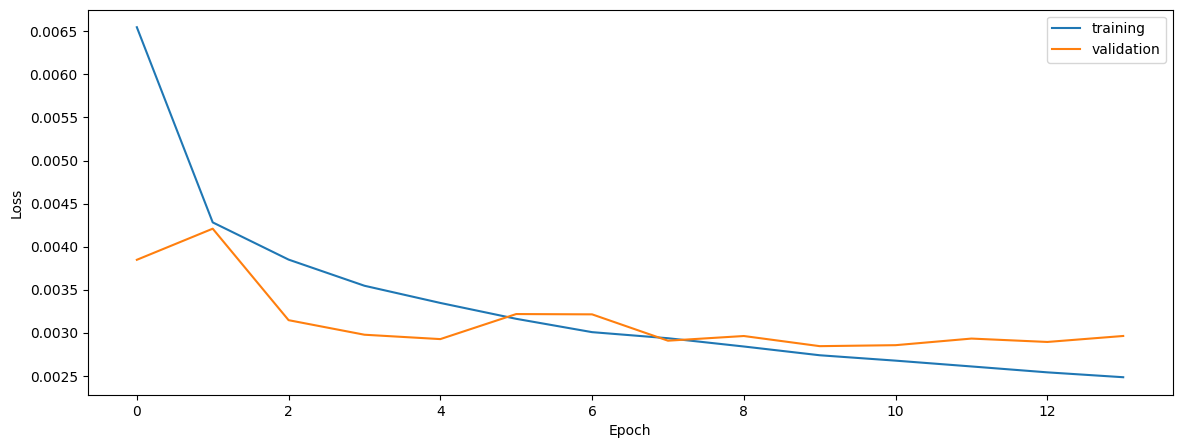

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.8480399338037997
0.8207183736964079
0.8215001288422555


In [8]:
print('normalized')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

normalized
0.8480399338037997
0.8207183736964079
0.8215001288422555


In [9]:
print('native')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

native
0.8467990874110283
0.821055376111795
0.8202015940390669


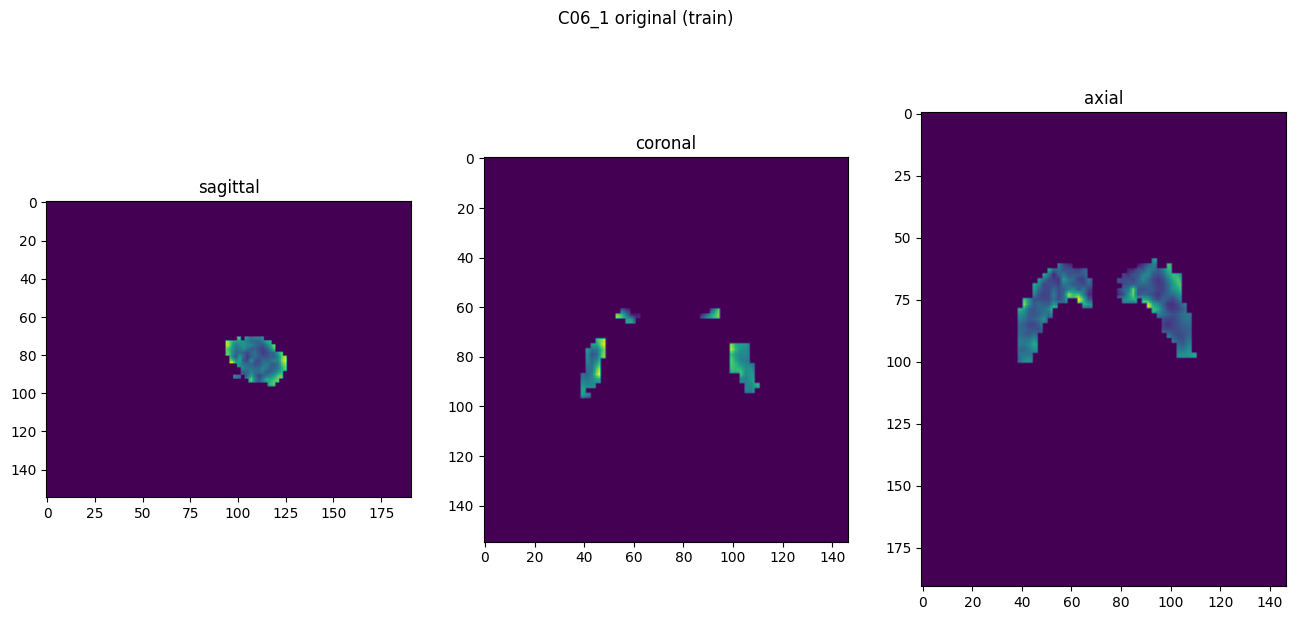

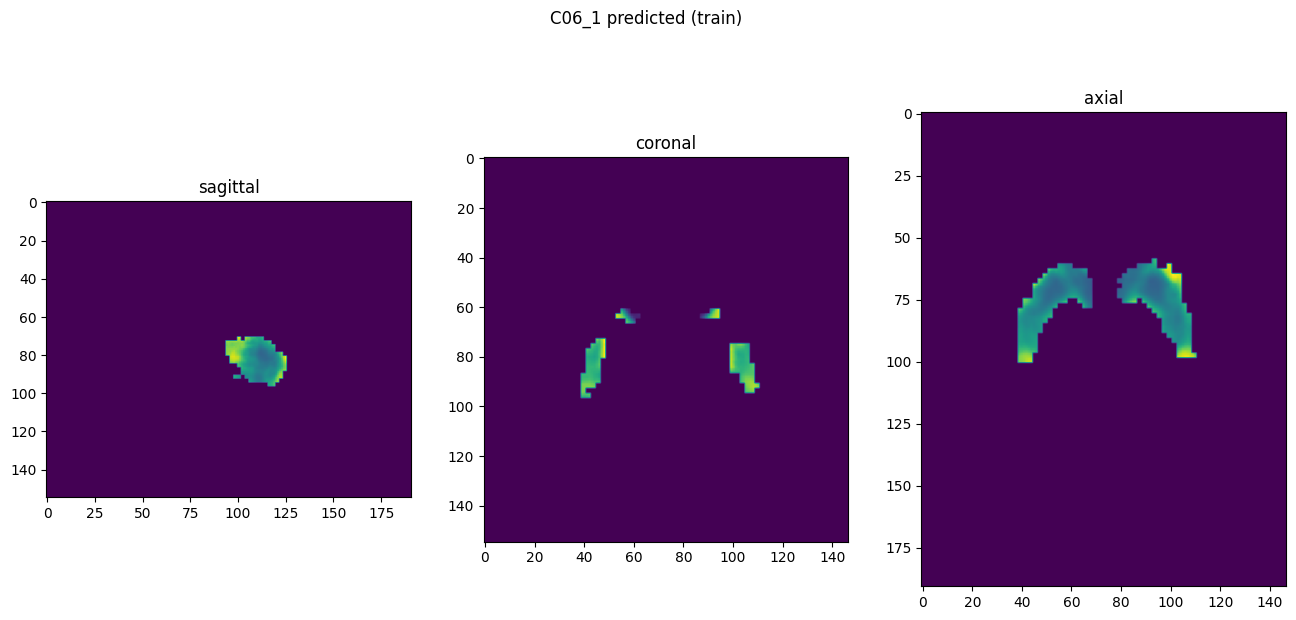

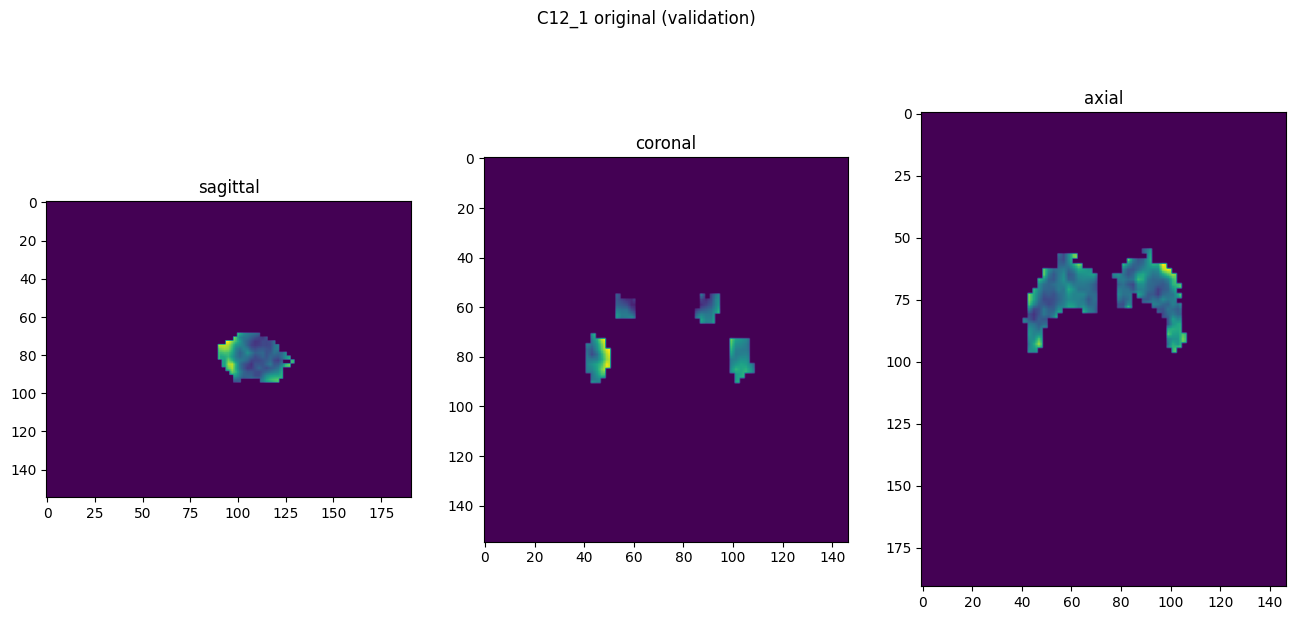

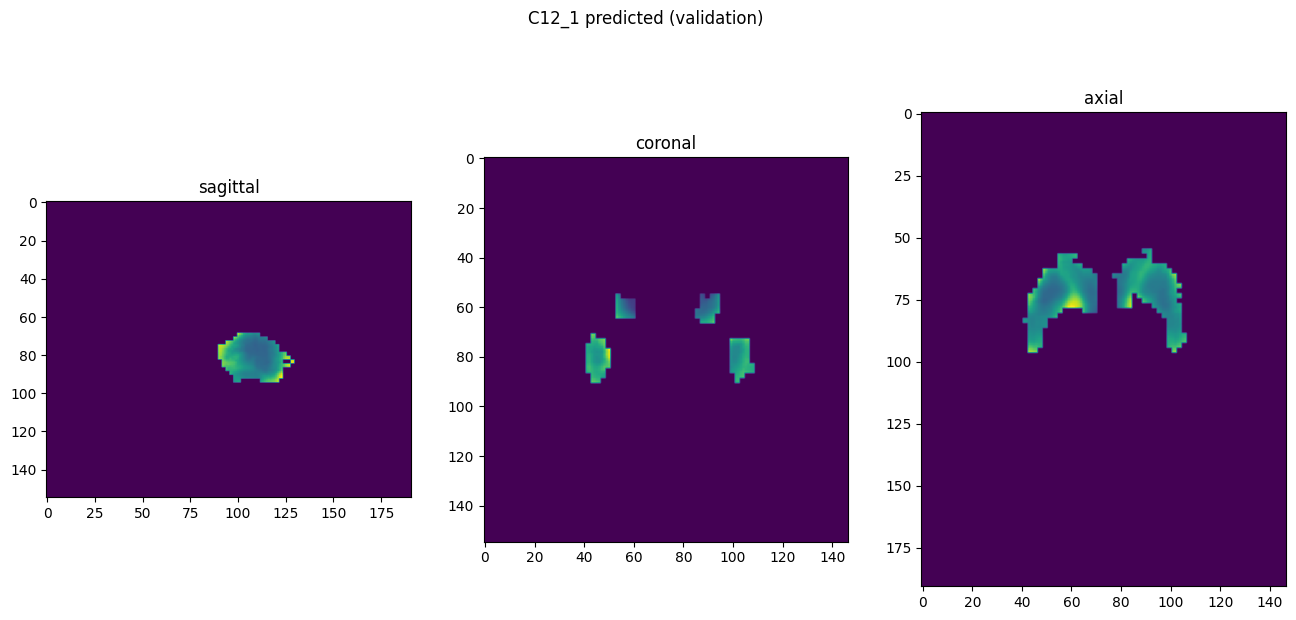

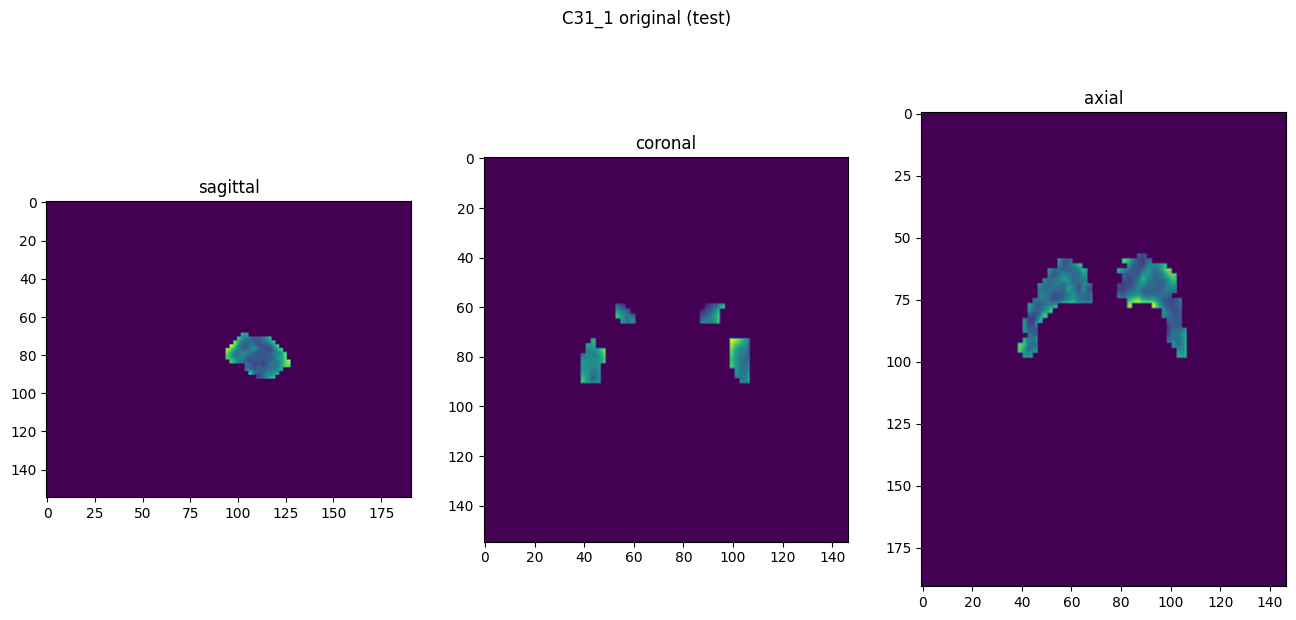

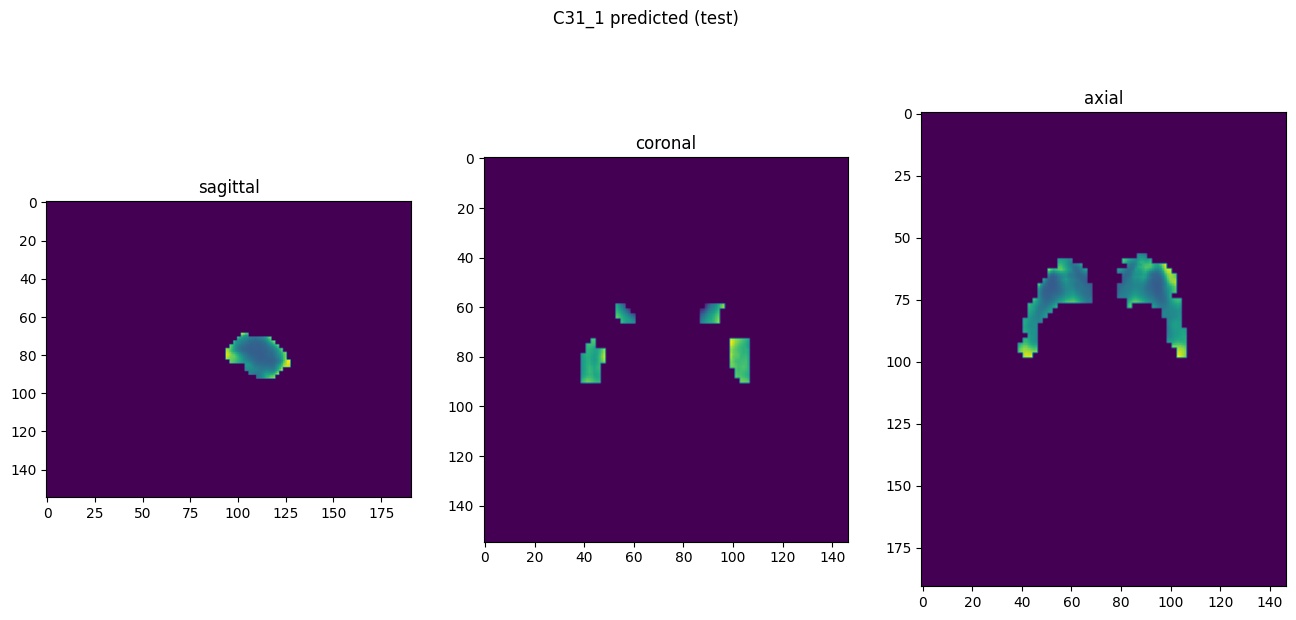

In [10]:
showResults(model, gen, threshold=None, background=False)